In [6]:
from datetime import datetime, timedelta
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from math import ceil
from pymongo import MongoClient
from tools.seibro_client import SeibroClient
from tools.openfigi_client import OpenFIGIClient
from dotenv import load_dotenv

load_dotenv()

True

In [7]:
today = datetime.today()
start_date = today - timedelta(days=365)

with SeibroClient() as seibro:
    net_buy_df = seibro.get_data(start_date=start_date.strftime('%Y-%m-%d'), end_date=today.strftime('%Y-%m-%d'))

INFO:tools.seibro_client:데이터 조회 완료: 12564개 레코드
INFO:tools.seibro_client:SeibroClient 리소스가 정리되었습니다.


In [8]:
pivot_df = net_buy_df.pivot(index="DATE", columns="KOR_SECN_NM", values="SUM_FRSEC_NET_BUY_AMT").sort_index()
ratio = pivot_df.iloc[-1] / pivot_df.sum()
ratio.dropna().sort_values(ascending=False)

KOR_SECN_NM
TRADR 2X LONG ASTS DAILY ETF                                                      1.000000
GRANITESHARES 2X LONG INTC DAILY ETF                                              1.000000
EATON CORP PLC                                                                    0.752823
WEBULL CORP WEBULL CORP MRGR 975699828 KYG8192N1034                               0.334893
BLOOM ENERGY CORP CL A                                                            0.200952
INCANNEX HEALTHCARE INC                                                           0.195208
BITMINE IMMERSION TECHNOLOGI                                                      0.150341
VOLATILITY SHARES TRUST XRP 2X ETF                                                0.133818
ISHARES SILVER TRUST ETF                                                          0.126181
WERIDE INC ADS                                                                    0.118480
SHARPLINK GAMING INC COM USD0.0001(POST REV SPLIT) SPLR 967265761 US8200141088

In [ ]:
# 여기까지만 확인해도 됨

In [9]:
# 모든 ISIN 리스트 가져오기
all_isins = list(net_buy_df["ISIN"].unique())

# US/해외 주식 구분 (정보용)
us_isins = [isin for isin in all_isins if isin.startswith("US")]
foreign_isins = [isin for isin in all_isins if not isin.startswith("US")]

In [10]:
openfigi_client = OpenFIGIClient(
    os.getenv("OPENFIGI_API_KEY")
)
isin_to_ticker = openfigi_client.map_isin_to_ticker(all_isins)

print(f"매핑 성공: {len(isin_to_ticker)}개")
print(f"매핑 실패: {len(all_isins) - len(isin_to_ticker)}개")
print(f"성공률: {len(isin_to_ticker) / len(all_isins) * 100:.1f}%")

# 매핑되지 않은 ISIN들 확인
unmapped_isins = set(all_isins) - set(isin_to_ticker.keys())

if unmapped_isins:
    print(f"\n매핑되지 않은 ISIN들 ({len(unmapped_isins)}개):")
    for isin in sorted(unmapped_isins)[:10]:  # 처음 10개만 표시
        print(f"  {isin}")
    if len(unmapped_isins) > 10:
        print(f"  ... 외 {len(unmapped_isins) - 10}개")

총 1226개 ISIN을 123개 배치로 처리합니다.
  매핑 실패: US25459Y5208 - No identifier found.


KeyboardInterrupt: 

In [7]:
ticker_list = list(isin_to_ticker.values())

NameError: name 'isin_to_ticker' is not defined

In [ ]:
# (2) price data도 batch로 가져오기
mongo_client = MongoClient(
    os.getenv("MONGODB_NF_URI")
)
db = mongo_client['quant']
price_collection = db["intrinio.us_stock_price"]
ticker_price_data = {}

# 기준일: settlement 데이터의 마지막 날짜 기준
if "DATE" in net_buy_df.columns:
    last_date = pd.to_datetime(net_buy_df["DATE"]).max()
else:
    last_date = pd.Timestamp.today()

start_date = last_date - pd.Timedelta(days=365)

# 여러 ticker의 데이터를 한 번에 가져오기 (주의: 너무 많은 ticker면 메모리/DB 부하 가능)
# 서비스 DB라면, 한번에 너무 많은 ticker를 넣지 말고, 적당히 batch로 나눠서 처리하는 것이 안전함
batch_size = 5
for i in tqdm(range(ceil(len(ticker_list) / batch_size)), desc="티커 배치별 가격 데이터 조회"):
    batch_tickers = ticker_list[i*batch_size:(i+1)*batch_size]
    price_cursor = price_collection.find(
        {
            "ticker": {"$in": batch_tickers},
            "date": {
                "$gte": start_date.to_pydatetime(),
                "$lte": last_date.to_pydatetime()
            }
        }
    ).sort([("ticker", 1), ("date", 1)])
    # 결과를 ticker별로 분리
    for doc in price_cursor:
        t = doc["ticker"]
        if t not in ticker_price_data:
            ticker_price_data[t] = []
        ticker_price_data[t].append(doc)
    time.sleep(0.2)  # 필요시 주석 해제

티커 배치별 가격 데이터 조회: 100%|██████████| 158/158 [01:02<00:00,  2.54it/s]


In [ ]:
# ticker_price_data의 각 티커별로 adjClose만 추출해서 데이터프레임으로 합치기
adjclose_dict = {}
for ticker, price_list in ticker_price_data.items():
    # price_list는 각 티커별로 날짜별 dict 리스트임
    for doc in price_list:
        date = doc["date"]
        adjclose = doc.get("adjClose", None)
        if date not in adjclose_dict:
            adjclose_dict[date] = {}
        adjclose_dict[date][ticker] = adjclose

# date를 인덱스로, 컬럼은 ticker로 하는 데이터프레임 생성
adjclose_df = pd.DataFrame.from_dict(adjclose_dict, orient="index").sort_index()
adjclose_df

,CRCL,PLTR,PLTU,SOXL,TSLL,AAPU,META,MSTY,PTIR,SMR,...,GXIG,DAIC,OKLL,QUBX,BGL,AEBI,SMU,KMRK,LAWR,OCEA
2024-07-22,NaN,28.46,NaN,52.360376,13.809416,31.483534,486.592380,11.742612,NaN,11.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.16
2024-07-23,NaN,28.81,NaN,49.986210,13.239258,31.751442,487.880242,11.715383,NaN,11.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.14
2024-07-24,NaN,26.60,NaN,42.438317,9.943939,29.936580,460.505677,11.657041,NaN,10.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.15
2024-07-25,NaN,26.63,NaN,39.351899,10.359478,29.642745,452.658701,11.392548,NaN,10.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.12
2024-07-26,NaN,27.18,NaN,41.468869,10.311159,29.755094,464.928337,11.863188,NaN,10.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-16,233.20,150.91,74.34,27.030000,11.840000,22.890000,702.910000,22.860000,23.54,46.09,...,25.240,5.70,25.70,25.9500,19.29,10.21,40.46,4.95,NaN,NaN
2025-07-17,235.08,153.99,77.36,27.320000,11.670000,22.870000,701.410000,22.830000,24.51,46.83,...,25.220,5.77,27.84,29.6500,19.00,10.24,41.26,4.45,3.52,NaN
2025-07-18,223.78,153.52,76.86,27.330000,12.400000,23.100000,704.280000,21.680000,24.36,50.25,...,25.275,5.63,29.37,28.9975,16.64,9.92,47.52,2.45,3.72,NaN
2025-07-21,216.10,151.79,75.08,27.500000,12.330000,23.390000,712.965000,21.710000,23.78,45.44,...,25.350,5.58,23.82,23.9400,15.15,9.26,38.22,2.15,3.34,NaN


In [19]:
pivot_net_buy = net_buy_df.pivot_table(index="DATE", columns="ISIN", values="SUM_FRSEC_NET_BUY_AMT")
pivot_net_buy = pivot_net_buy.loc[:, list(isin_to_ticker.keys())].rename(columns=isin_to_ticker)
pivot_net_buy

ISIN,PLTR,TSLL,SOXL,CRCL,PLTU,PTIR,META,SMR,MSTY,AAPU,...,BCT,APH,OMEX,BWX,IBND,ZENA,TRVC,TPD,NOC,INEO
DATE,,,,,,,,,,,,,,,,,,,,,
2025-01-01,NaN,3318472.0,55635885.0,NaN,NaN,NaN,NaN,NaN,2229505.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-02,NaN,4973594.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-03,10058598.0,20535137.0,65451428.0,NaN,NaN,1813904.0,NaN,NaN,3734365.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-06,9057260.0,146764537.0,NaN,NaN,NaN,NaN,NaN,2219681.0,3308896.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-07,5085192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1511401.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-16,NaN,NaN,97549076.0,NaN,NaN,NaN,2776013.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-17,NaN,9049023.0,NaN,3752568.0,NaN,NaN,12058673.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-18,NaN,NaN,107006605.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
filtered_stock_dict = {}

window_size = 100
date_index = pivot_net_buy.index[window_size:]
for i, date in enumerate(date_index, start=window_size):
    date_df = pivot_net_buy.iloc[i - window_size:i]
    filtered_stock = (date_df.iloc[-1] / date_df.sum()).sort_values(ascending=False).dropna()
    filtered_stock = filtered_stock[filtered_stock == 1].index.tolist()

    if filtered_stock:
        filtered_stock_dict[date] = filtered_stock

# 누적 수익률 계산 함수
def calc_cumulative_return(adjclose_df, ticker, date, max_days=15):
    """
    adjclose_df: 종가 데이터프레임
    ticker: 티커(str)
    date: 기준 날짜 (Timestamp)
    max_days: int, 최대 며칠 후까지 누적수익률 계산
    """
    if ticker not in adjclose_df.columns:
        return None
    if date not in adjclose_df.index:
        return None

    idx = adjclose_df.index.get_loc(date)
    # max_days+1 만큼의 데이터가 있어야 함 (기준일 포함)
    if idx + max_days >= len(adjclose_df):
        return None

    price_series = adjclose_df[ticker].iloc[idx:(idx + max_days + 1)]
    if price_series.isnull().any() or price_series.iloc[0] == 0:
        return None

    # 기준일을 1로 정규화
    normed = price_series / price_series.iloc[0]
    return normed.values  # numpy array 반환

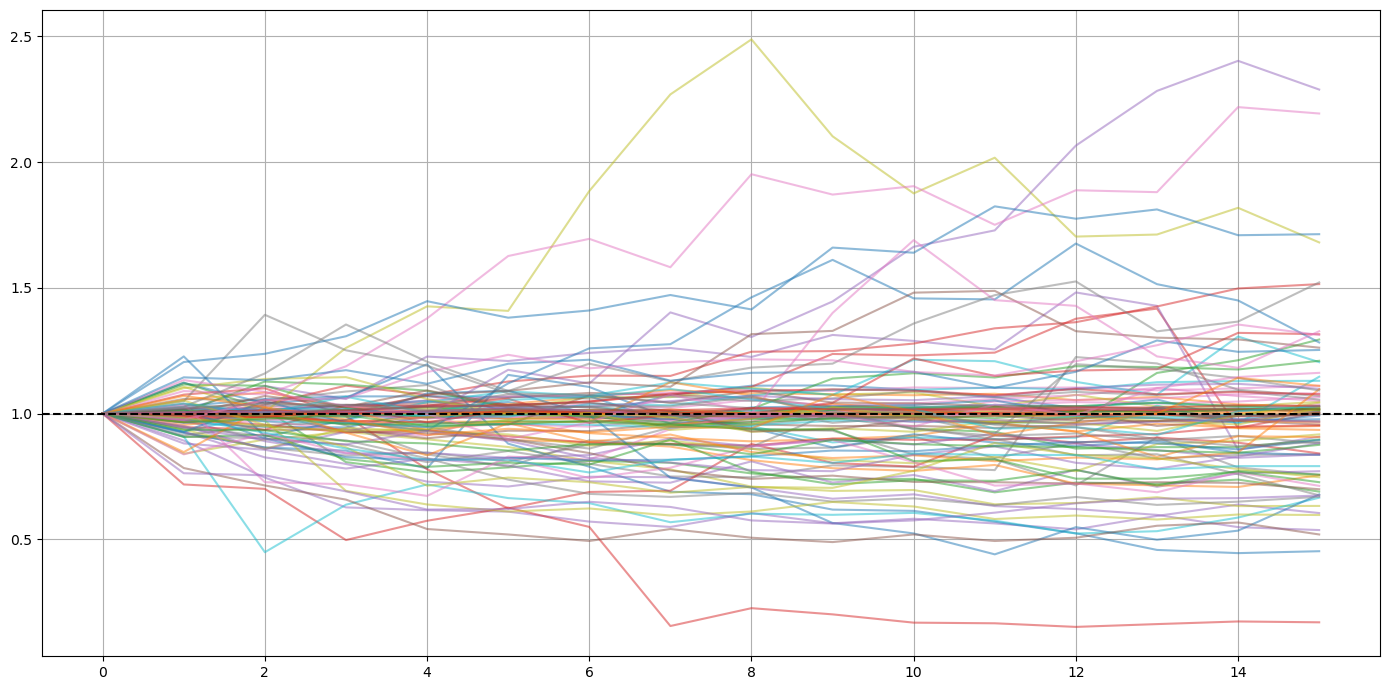

In [116]:
max_cum_days = 15  # 최대 15일 후까지 누적수익률
cumulative_returns = []  # 각 종목별 누적수익률 시계열 저장
labels = []  # 라벨(티커+날짜) 저장

for date, ticker_list in filtered_stock_dict.items():
    for ticker in ticker_list:
        cum_rtn = calc_cumulative_return(adjclose_df, ticker, date, max_days=max_cum_days)
        if cum_rtn is not None:
            cumulative_returns.append(cum_rtn)
            labels.append(f"{ticker} ({date.strftime('%Y-%m-%d')})")

# x축: 0~max_cum_days (0=진입일, 1=+1일, ...)
x = list(range(max_cum_days + 1))

plt.figure(figsize=(14, 7))
for i, cum_rtn in enumerate(cumulative_returns):
    plt.plot(x, cum_rtn, alpha=0.5)
plt.grid(True)
plt.axhline(y=1, color='k', linestyle='--')
#plt.legend(labels, loc='upper left')
plt.tight_layout()

In [133]:
cum_res = pd.DataFrame(cumulative_returns, index=labels).T
t = ((cum_res.iloc[-1] - 1) * 100)
t.mean()

-0.5232215170063497

In [140]:
cum_res

,CLSK (2025-05-28),ABNB (2025-05-28),IGOV (2025-05-28),SEDG (2025-05-28),RUN (2025-05-28),BSX (2025-05-28),CAH (2025-05-28),LITM (2025-05-29),CCO (2025-05-29),SH (2025-05-29),...,ABSI (2025-06-25),AISP (2025-06-25),BIYA (2025-06-25),ARQQ (2025-06-25),GPUS (2025-06-26),QQMG (2025-06-26),FI (2025-06-26),BAC (2025-06-26),ORCX (2025-06-26),NVOX (2025-06-27)
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.963776,0.997591,1.007715,0.981087,1.014815,0.999904,1.005616,0.925121,1.000000,1.001912,...,0.981884,1.039855,1.144089,1.070411,0.965035,1.005887,1.005661,0.992836,0.976298,1.023847
2,0.947311,1.002565,1.006750,1.055556,1.109630,1.007176,1.008555,0.864734,0.981308,0.996416,...,0.949275,1.001812,1.132588,1.025580,0.979021,1.012309,1.006127,0.997050,1.053800,1.038156
3,0.945115,1.007383,1.014947,1.010638,1.057778,0.996747,1.013844,0.833333,1.028037,0.990681,...,0.931159,1.067029,1.172524,0.976530,0.993007,1.000268,1.007703,1.014539,1.060948,1.034976
4,1.010977,1.032875,1.007715,1.070331,1.226667,0.986508,1.015346,0.845411,1.018692,0.991398,...,0.938406,1.003623,1.118371,0.914557,0.951049,1.009633,1.006361,1.026338,1.164786,1.012719
5,1.046103,1.037616,1.014947,1.032506,1.208889,0.980098,1.006139,0.809179,1.018692,0.996416,...,0.974638,1.054348,1.198083,0.939610,0.958042,1.020337,1.024451,1.030973,1.233634,1.015898
6,0.990121,1.066993,1.013018,1.048463,1.241481,0.983925,1.006465,0.876812,1.065421,0.987097,...,1.003623,1.067029,1.214058,0.925105,0.972028,1.012577,1.011380,1.025284,1.179834,1.028617
7,1.074643,1.093029,1.010608,1.075059,1.260741,0.976844,1.010318,0.879227,1.065421,0.986380,...,0.934783,1.097826,1.130831,0.947785,0.958042,1.013112,0.994514,0.993468,1.203160,1.028617
8,1.110867,1.080361,1.010849,1.106383,1.225185,0.957229,1.003200,0.859903,1.102804,0.980884,...,0.956522,1.056159,1.162141,0.940401,0.937063,1.021408,0.997607,0.986936,1.215576,1.066773
9,1.111965,1.076863,1.013500,1.236998,1.312593,0.950531,0.999673,0.864734,1.074766,0.983751,...,1.025362,1.018116,1.164696,1.074103,0.937063,1.018732,0.990313,0.989676,1.211813,1.001590
